In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import pathlib, dataclasses, typing, numpy as np, scipy as sp, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, pymc3 as pm, arviz as az

@dataclasses.dataclass
class Bayes:
    times : np.ndarray
    y0    : np.ndarray
    obs   : dict
    ODE   : typing.Any
    params: dict
    sigmas: dict = None
    models: list = None
    tune  : int = 100
    cores : int = 4
    path  : str = '/home/jupyter/'
    name  : str = 'english_boarding'

    def __post_init__(self):
        self.draws = 4 * self.tune
        self.coords = {'t': self.times[1:], 'cls': list(self.obs.keys())}
        self.sigmas = {key: 1.0 for key,val in self.obs.items() if val is not None}
        self.models = []
        self.results = dict()
        
        # create pymc3 ODE object
        self.ODE_pymc3 = pm.ode.DifferentialEquation(
            func     = self.ODE,
            times    = self.coords['t'],
            t0       = self.times[0],
            n_states = len(self.y0),
            n_theta  = len(self.params))

        self.path = pathlib.Path(self.path)
        self.path.mkdir(parents=True, exist_ok=True)
        
    def make_model(self):
        # create pymc3 model object
        with pm.Model(coords=self.coords) as model:
            # store params and sigmas in model for future reference
            model.params = self.params.copy()
            model.sigmas = self.sigmas.copy()

            # create priors for params
            params_prior = [pm.Lognormal(key, mu=pm.math.log(val), sigma=1.0) for key,val in model.params.items()]

            # apply ODE
            curves = self.ODE_pymc3(y0=self.y0, theta=params_prior)
            Y = pm.Deterministic("Y", curves, dims=('t','cls'))  # Y is determined by ODS and depends on 't' and 'cls'

            # create normally-distributed "observed RV" for each class with observed data
            # mean = column of Y that corresponds to this class
            # sigma = noise/error modeled with HalfCauchy prior
            # Each of these RV's depends only on t because each class has a separate variable
            cls = 0
            for key, val in self.obs.items():
                if val is not None:  # so this RV has observed data
                    pm.Normal(key, mu=Y[:,cls], sigma=pm.HalfCauchy(f'sigma_{key}', model.sigmas[key]), observed=val, dims= 't')
                cls += 1
        self.models.append(model)
        return model
    
    def adjust(self, idata):
        # Record ode solution and param names for plotting purposes
        y_ode = sp.integrate.odeint(self.ODE, self.y0, self.times, (list(self.params.values()),), rtol=1e-8)[1:]  # get ODE predictions
        idata.posterior = idata.posterior.assign(y_ode=(('t','cls'), y_ode))  # insert ode solution into posterior
        idata.posterior.attrs['params'] = list(self.params.keys())  # record param names
        return idata
    
    def bayesiate(self, method='MCMC', n=50000, model=None):
        if model is None:
            model = self.models[-1]
        with model:
            if method == 'MAP':
                mp = pm.find_MAP()
                # Update params and sigma base on results of MAP
                self.params = {key:mp[key]            for key in self.params.keys()}
                self.sigmas = {key:mp[f'sigma_{key}'] for key in self.sigmas.keys()}
                return mp
            else:
                # When we defined params, we used estimates someone gave us.  But we don't want to rely on them.
                # So, we first apply MAP to get our own point estimates for params.
                self.bayesiate('MAP', n, model)

                # Do the Bayesian stuff with revised params and sigmas
                if method == 'MCMC':
                    idata = pm.sample(tune=self.tune, draws=self.draws, cores=self.cores, chains=self.cores, return_inferencedata=True)
                elif method == 'ADVI':
                    s = min(n, self.draws * self.cores)
                    idata = az.from_pymc3(pm.fit(method="advi", n=n).sample(s))
                else:
                    raise Exception(f'Unknown method "{method}"')
        idata = self.adjust(idata)
        self.results[method] = idata
        
        # Save results
        file = self.path / f'{self.name}_{method}.netcdf'
        if file.is_file():  # delete file if already exists
            file.unlink()
        idata.to_netcdf(file)  # save
        return idata
    
    def from_file(self, method='MCMC'):
        file = self.path / f'{self.name}_{method}.netcdf'
        idata = az.from_netcdf(file)  # load from file
        self.results[method] = idata
        return idata

    def visualize(self, method='MCMC', plot_pct=98, **kwargs):
        try:
            idata = self.from_file(method)  # load from file
        except:
            idata = self.bayesiate(method, **kwargs)

        P = idata.posterior.stack(sample=["chain", "draw"])  # grab posterior and combine chain & draw into one index
        colors = {cls:f'C{i}' for i, cls in enumerate(P.coords['cls'].values)}  # set color for each class

        # To avoid overplotting, take random subset of 500 samples
        samp = np.random.permutation(P.sizes['sample'])[:500]
        for cls, clr in colors.items():
            B = P['Y']    .sel(cls=cls).isel(sample=samp)
            O = P['y_ode'].sel(cls=cls)
            B.plot.line(x='t', color=clr, alpha=0.05, linewidth=2, add_legend=False);  # plot traces
            O.plot.line(x='t', color='black', alpha=1.00, linewidth=3);  # plot ODE solution
            if cls in idata.observed_data.data_vars:
                idata.observed_data.plot.scatter(x='t', y=cls, color='black', s=100)  # plot observed data

            # restrict y range so fly-aways don't skew the image too much
            y = np.concatenate((B.values.flatten(), O.values.flatten()))
            fence = (100-plot_pct)/2
            plt.ylim(np.percentile(y, [fence, 100-fence]))
            
            plt.title(f'{method}, class={cls}')
            plt.ylabel(None)
            plt.xticks(P['t'], rotation='vertical')
            plt.show()
        
        az.plot_posterior(idata, var_names=P.attrs['params'])  # plot posterior for parameters
        plt.show()

0, dim: t, 21 =? 21


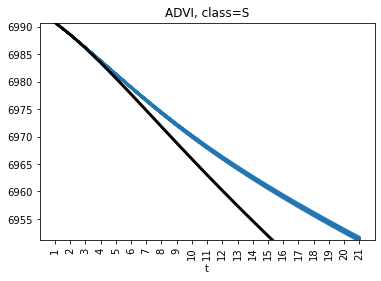

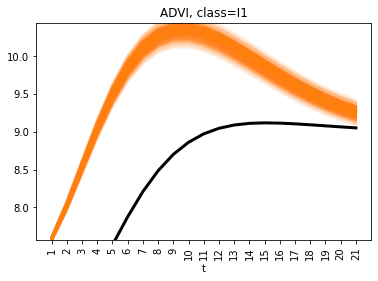

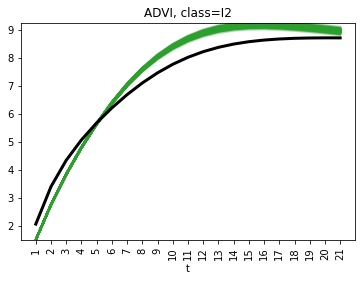

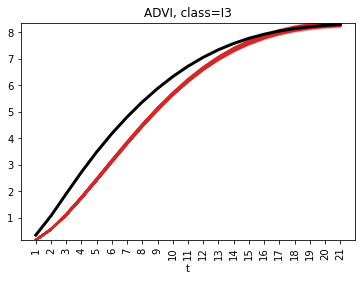

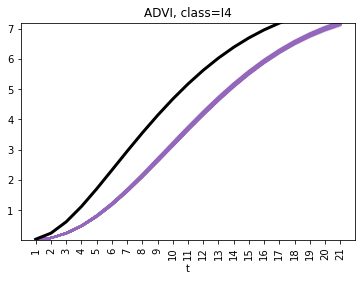

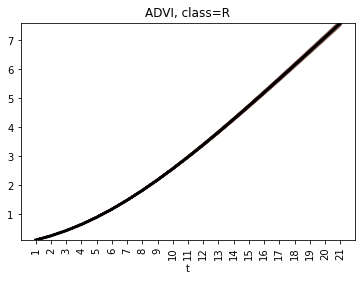

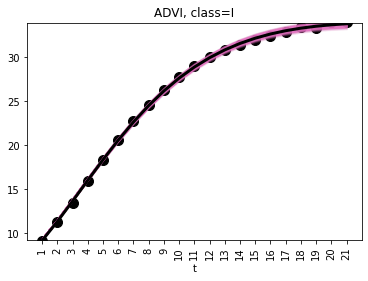

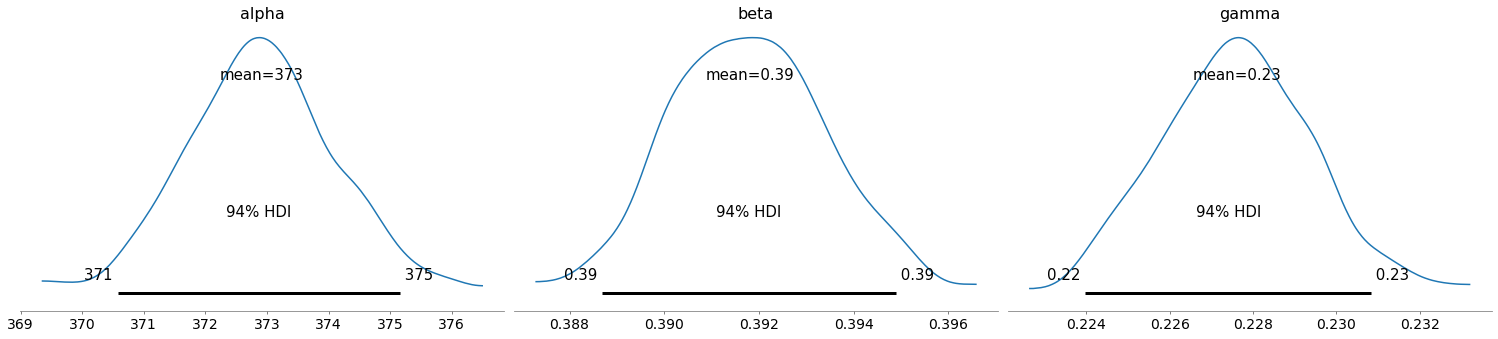

/opt/conda/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/conda/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/conda/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0, dim: t, 21 =? 21


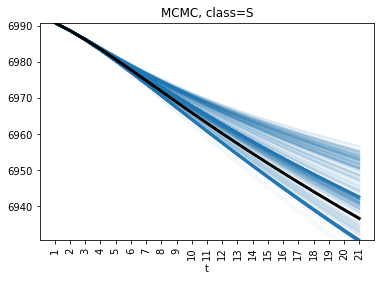

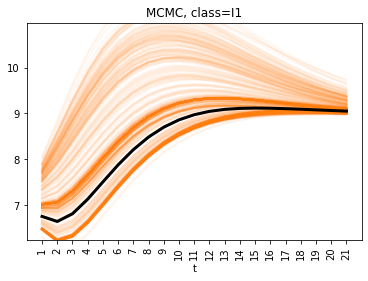

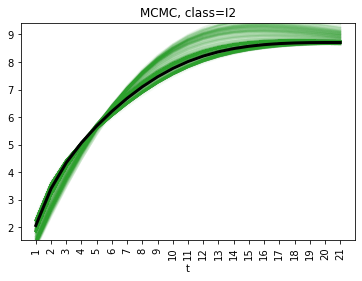

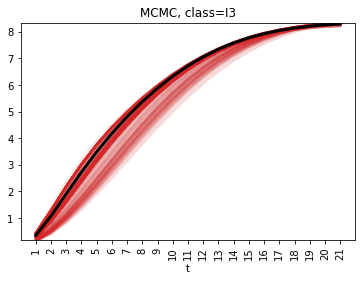

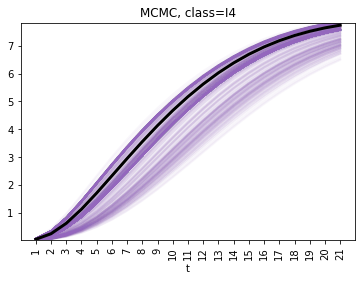

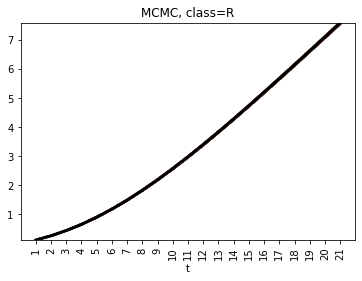

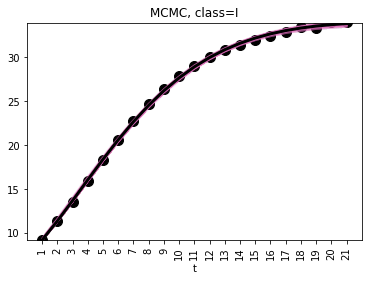

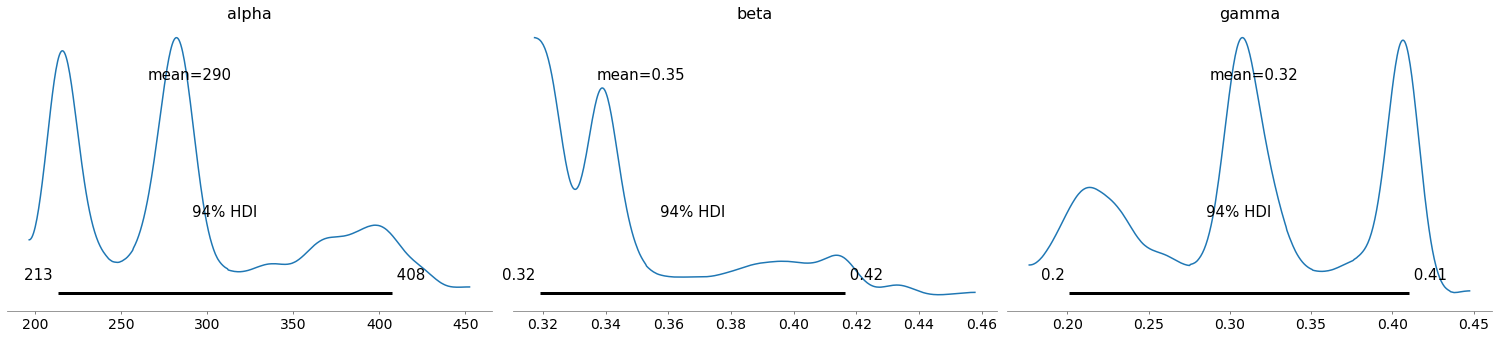

In [11]:
# HIV Example

# Inital conditions
times = np.arange(0, 22)
y0 = np.array([6992.7, 7.3 , 0, 0,0,0,7.3])

# Declare class names and observed values (if any).  If not observed, set = None
obs = {'S' : None,
       'I1': None,
       'I2': None,
       'I3': None,
       'I4': None,
       'R' : None,
       'I' : np.array([9.2, 11.3, 13.5, 15.9, 18.3, 20.6, 22.7, 24.6, 26.3, 27.8,29.0, 30.0, 30.8, 31.4, 31.9, 32.4, 32.8, 33.4, 33.3, 34.0, 34.0]),
      }

# create ODE system
def ODE(y, t, p):
    i_s = y[1]+y[2]+y[3]+y[4]
    n_s = y[0]+y[1]+y[2]+y[3]+y[4]
    lamb = p[1]*np.exp(-p[0]*i_s /n_s) * i_s / n_s
    
    dS   = Lambda - lamb * y[0] - mu *    y[0]
    dI_1 = lamb * y[0] - (p[2] + mu)* y[1]
    dI_2 = p[2] * y[1] - (p[2] + mu)* y[2]
    dI_3 = p[2] * y[2] - (p[2] + mu)* y[3]
    dI_4 = p[2] * y[3] - (p[2] + mu)* y[4]
    dR   = mu * y[1] + mu * y[2] + mu * y[3] + mu * y[4]
    dI   = dI_1 + dI_2 + dI_3 + dI_4
    return [dS, dI_1, dI_2, dI_3, dI_4, dR, dI]



# set initial parameter values
params = {'alpha': 235.567,'beta': 0.332276 , 'gamma': 0.349035}
Lambda = 100
mu     = 1/70

b = Bayes(times, y0, obs, ODE, params, tune=30, name='AIDS')
b.make_model()

# We have 2 options 1) MCMC - slow & accurate 2) Variational Inference ('ADVI') - fast & less accurate
for method in ['ADVI', 'MCMC']:
    b.visualize(method)